This is an implementation of the quantum autoencoder of  https://arxiv.org/abs/1612.02806.
In order to encrypt given image data using this autoencoder, the reference state can be randomnly chosen and kept secret. The image can then be compressed with respect to this reference state. Decoding the encryption would require the chosen reference state as a key to decompress the image.

In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [24]:
import pennylane as qml
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

The following cell implements two circuits on 2 qubits using pennylane. 
The function "circuit" first performs an amplitude embedding of the inputted data to compress, and then applies a series of rotations and controlled rotations. It then outputs the density matrix of the "trash" qubit.
The second function "cost" takes in the density matrix of the trash state and returns the fidelity of the trash state with the reference state which in this case is the |0> state. Since we want the expectation value <0|A|0>, we just need the first index of the density matrix.

In [25]:
n_qubits = 2
n_trash = 1

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')

def circuit(inputs, weights):
    
    #Initializing the wave function
    qml.AmplitudeEmbedding(features = inputs, wires = list(range(n_qubits)), normalize = True)
    
    #Applying the rotations
    qml.RX(weights[0], wires = [0])
    qml.RX(weights[1], wires = [1])
    qml.CRX(weights[2], wires = [0, 1])
    qml.CRY(weights[3], wires = [0, 1])
    qml.CRX(weights[4], wires = [1, 0])
    qml.CRY(weights[5], wires = [1, 0])
    qml.CRX(weights[6], wires = [0, 1])
    qml.CRY(weights[7], wires = [0, 1])
    qml.RY(weights[8], wires = [0])
    qml.RY(weights[9], wires = [1])
    
    #Tracing out the second qubit with density_matrix
    return qml.density_matrix(wires = [0])
    
def cost(density_mat):
    return 1-density_mat[0][0]

The following cell builds a neural network with the quantum layer defined by the circuit in the previous cell. Additional classical or quantum layers can easily be added here.

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.weight_shapes = {"weights": 10}
        self.qlayer = qml.qnn.TorchLayer(circuit, self.weight_shapes)
        #Additional classical or quantum layers can be added here
    
    def forward(self, data):
        return self.qlayer.forward(data)
        
    
    def backward(self, data):
        return self.qlayer.forward(data)

The following cell generates the synthetic binary images which will be used to train the model. Some examples are shown visually.

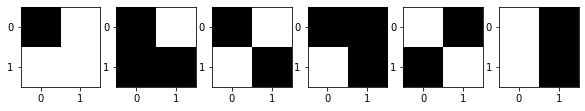

In [27]:
class binary_dataset(Dataset):
    def __init__(self, n_samples):
        self.n_samples = n_samples
        unnorm_data = [np.random.randint(0, 2, size=4) for _ in range(2*(n_samples+1))]
        unnorm_data = [x for x in unnorm_data if sum(x)!=0 ]
        self.data = [x/np.linalg.norm(x) for x in unnorm_data]
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, i):
        return self.data[i]

#Sampling the dataset for training data
n_samples = 10
X_train = binary_dataset(n_samples)
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, collate_fn = None)

#Showing some examples of the training data
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))
while n_samples_show > 0:
    images = data_iter.__next__()
    axes[n_samples_show - 1].imshow(images.reshape(2, 2), cmap='gray')
    n_samples_show -= 1

In [28]:
model = Net()

The following cell trains the model. Each data point will be trained separately, meaning that a separate set of weights will be generated for each data point, and stored in weights_list.

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
weights_list = []
data_list = []
model.train()

for batch_idx, data in enumerate(train_loader):
    data_list.append(data)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = cost(output)
        loss.backward()
        optimizer.step()
        '''
        print('Training [{:.2f}%]\tLoss: {:.10f}'.format(
        100. * (epoch + 1) / epochs, loss))'''
    weights_list.append(model.parameters())

The following cells evaluate the model using Qiskit. I chose to use Qiskit so that I could easily make use of the unitary and statevector simulators.

In [30]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector, state_fidelity

In [31]:
decompressed_states = []
j=0

for data in data_list:
    data = data.detach().numpy()[0]
    print("Wavefunction=", data)
    weights = weights_list[j]
    params = []
    
    for i in model.parameters():
        params = i.detach().numpy()
        
    #Getting the unitary equivalent of the encoding circuit   
    qc = QuantumCircuit(2,1)
    qc.initialize(data, [1, 0])
    qc.rx(params[0], 0)
    qc.rx(params[1], 1)
    qc.crx(params[2], 0, 1)
    qc.cry(params[3], 0, 1)
    qc.crx(params[4], 1, 0)
    qc.cry(params[5], 1, 0)
    qc.crx(params[6], 0, 1)
    qc.cry(params[7], 0, 1)
    qc.ry(params[6], 0)
    qc.ry(params[7], 1)
    
    backend = Aer.get_backend("unitary_simulator")
    job = execute(qc, backend)
    U = np.asmatrix(job.result().get_unitary().data)
    U_dag = U.H
    
    #circ uses the unitaries of the previous circuit to compress and decompress the data
    circ = QuantumCircuit(3, 1)
    circ.unitary(U, [0, 1])
    circ.measure(0, 0)
    circ.unitary(U_dag, [2, 1])
    
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc, backend)
    new_state = job.result().get_statevector()
    decompressed_states.append(new_state)
    
    print("Decompressed Wavefunction = ", new_state)
    print("Fidelity=", state_fidelity(Statevector(data), new_state))
    j+=1
    print("------------------------------------------------------------------")

Wavefunction= [0.70710678 0.         0.70710678 0.        ]
Decompressed Wavefunction =  Statevector([-0.45974451-0.07468849j, -0.2262144 -0.82277737j,
              0.15497221+0.04825377j,  0.07087897+0.15346797j],
            dims=(2, 2))
Fidelity= 0.0467924758295793
------------------------------------------------------------------
Wavefunction= [0.70710678 0.         0.         0.70710678]
Decompressed Wavefunction =  Statevector([-0.13782997-0.06452819j, -0.00628863-0.4027899j ,
              0.8403959 -0.13033011j,  0.17741583-0.24460618j],
            dims=(2, 2))
Fidelity= 0.048565547576160745
------------------------------------------------------------------
Wavefunction= [0. 0. 1. 0.]
Decompressed Wavefunction =  Statevector([-0.18030369-0.15277807j, -0.37022217-0.564151j  ,
             -0.0474492 +0.14736496j, -0.34915774+0.58561049j],
            dims=(2, 2))
Fidelity= 0.023967858898713702
------------------------------------------------------------------
Wavefunction= [0.

The following cell produces some visuals of the decompressed data. Since the binary input data is entirely real, I chose to ony display the real part of the decompressed statevectors, where the decompressed statevectors refer to those that have undergone compression and decompression. One of the reasons the model performed so poorly is likely the choice of rotations I implemented in the circuit. I was not able to find a combination that worked well.

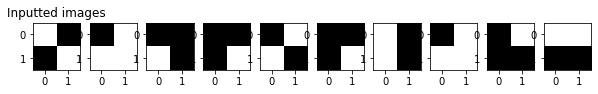

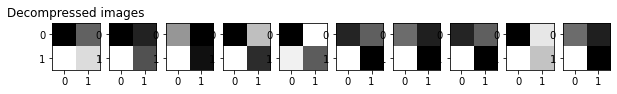

In [32]:
data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
axes[0].set_title("Inputted images")
for i in range(10):
    images = data_iter.__next__()
    axes[i].imshow(images.reshape(2, 2), cmap='gray')
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
axes[0].set_title("Decompressed images")
for i in range(10):
    images = np.array(list(decompressed_states[i].to_dict().values())).real
    axes[i].imshow(images.reshape(2, 2), cmap='gray')